TRAINING PHASE: Processing training images...


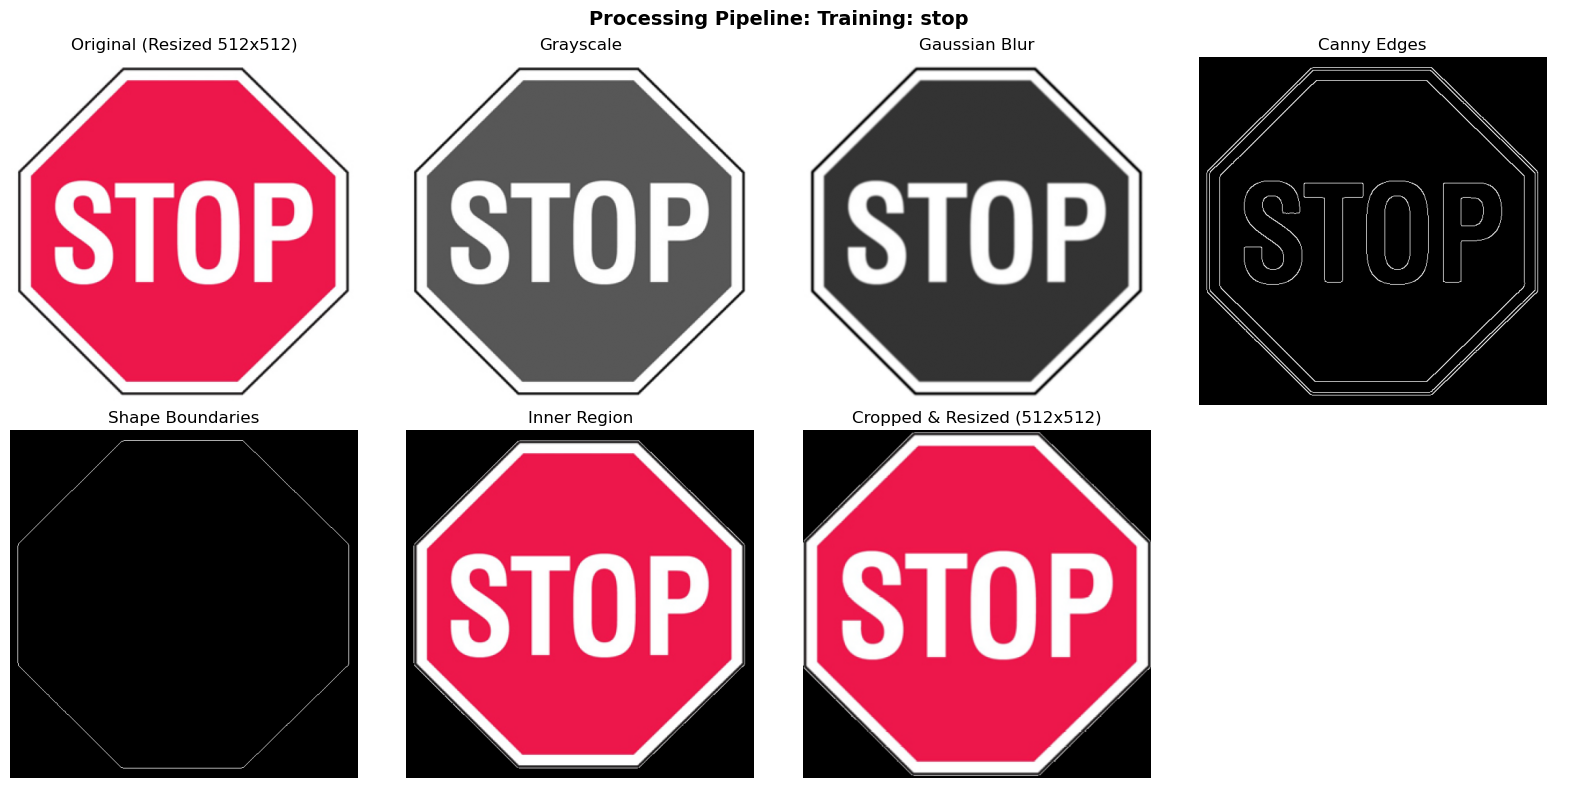

✓ Processed: stop


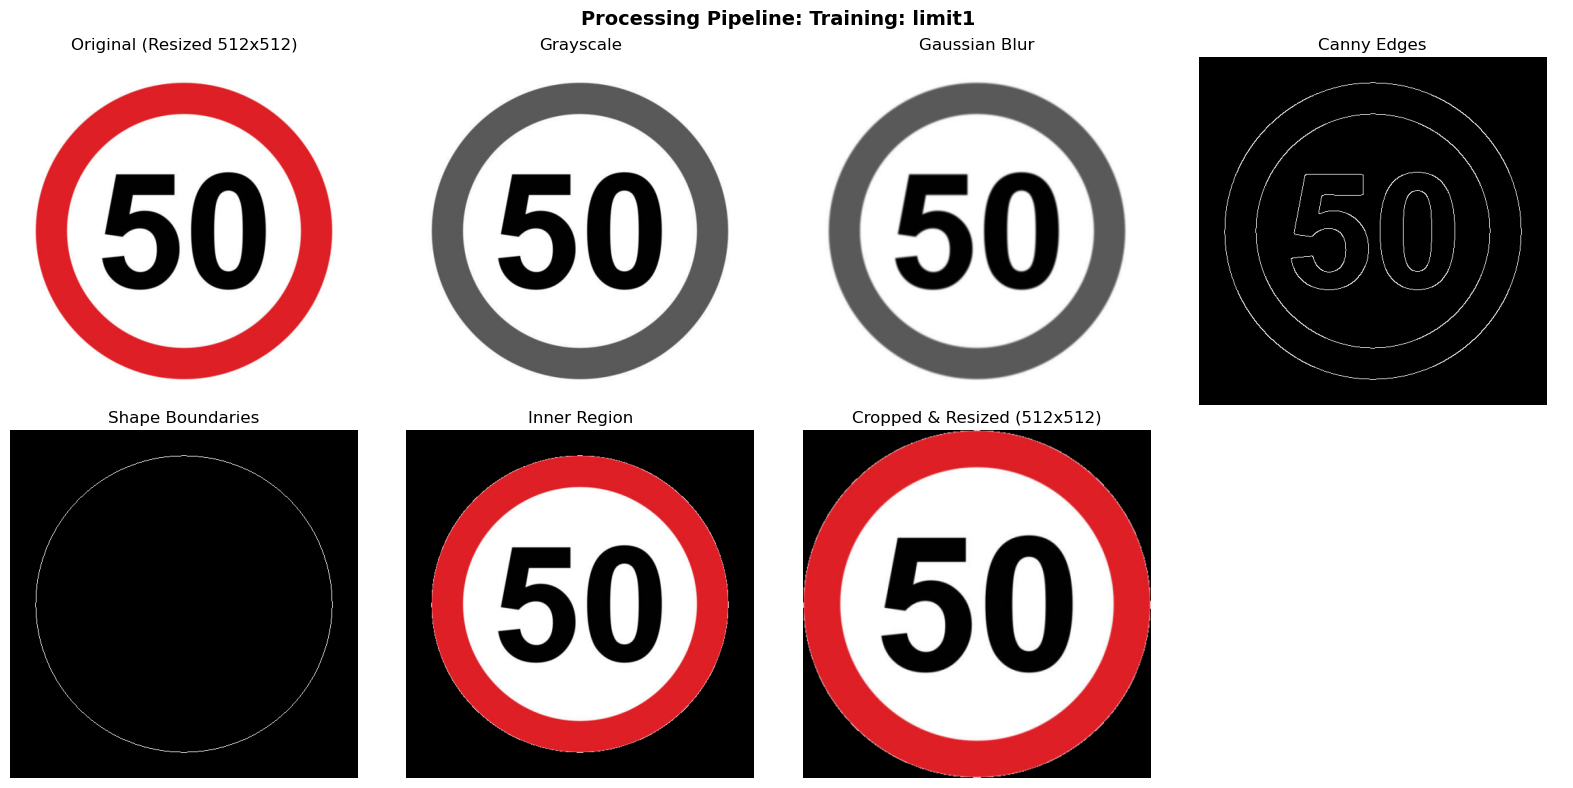

✓ Processed: limit1


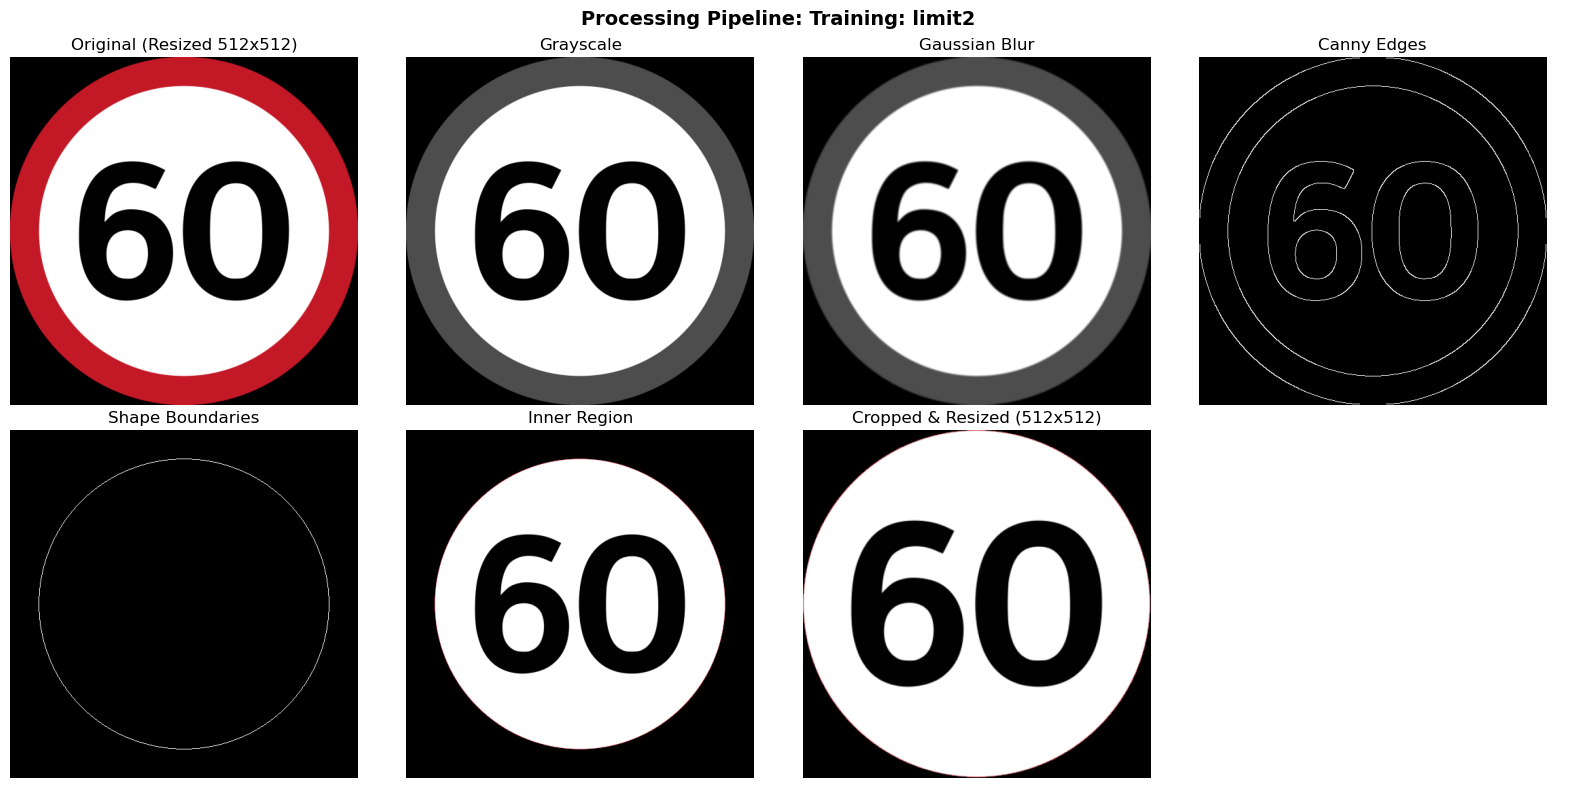

✓ Processed: limit2


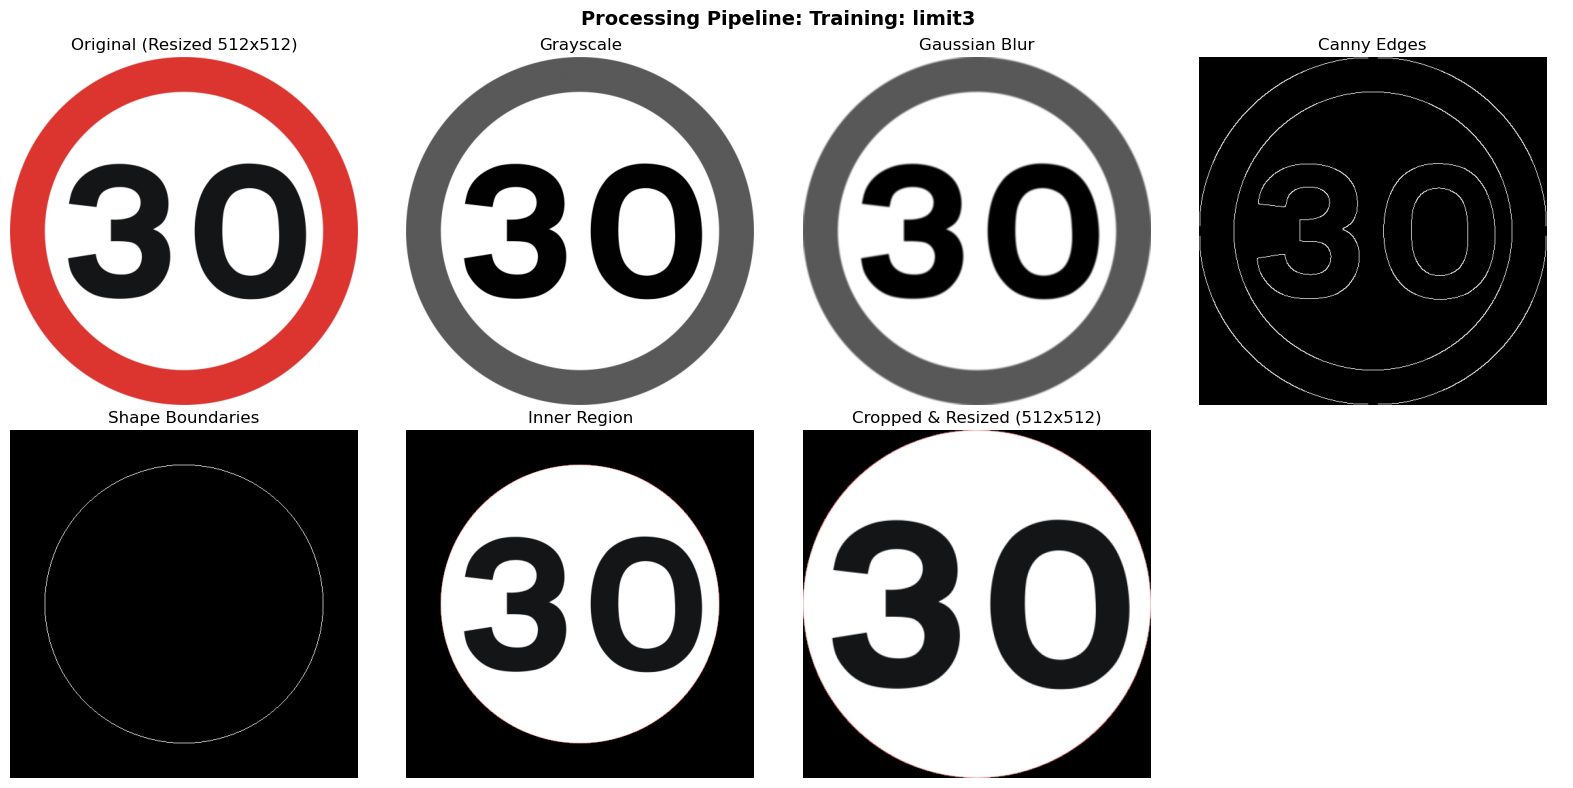

✓ Processed: limit3


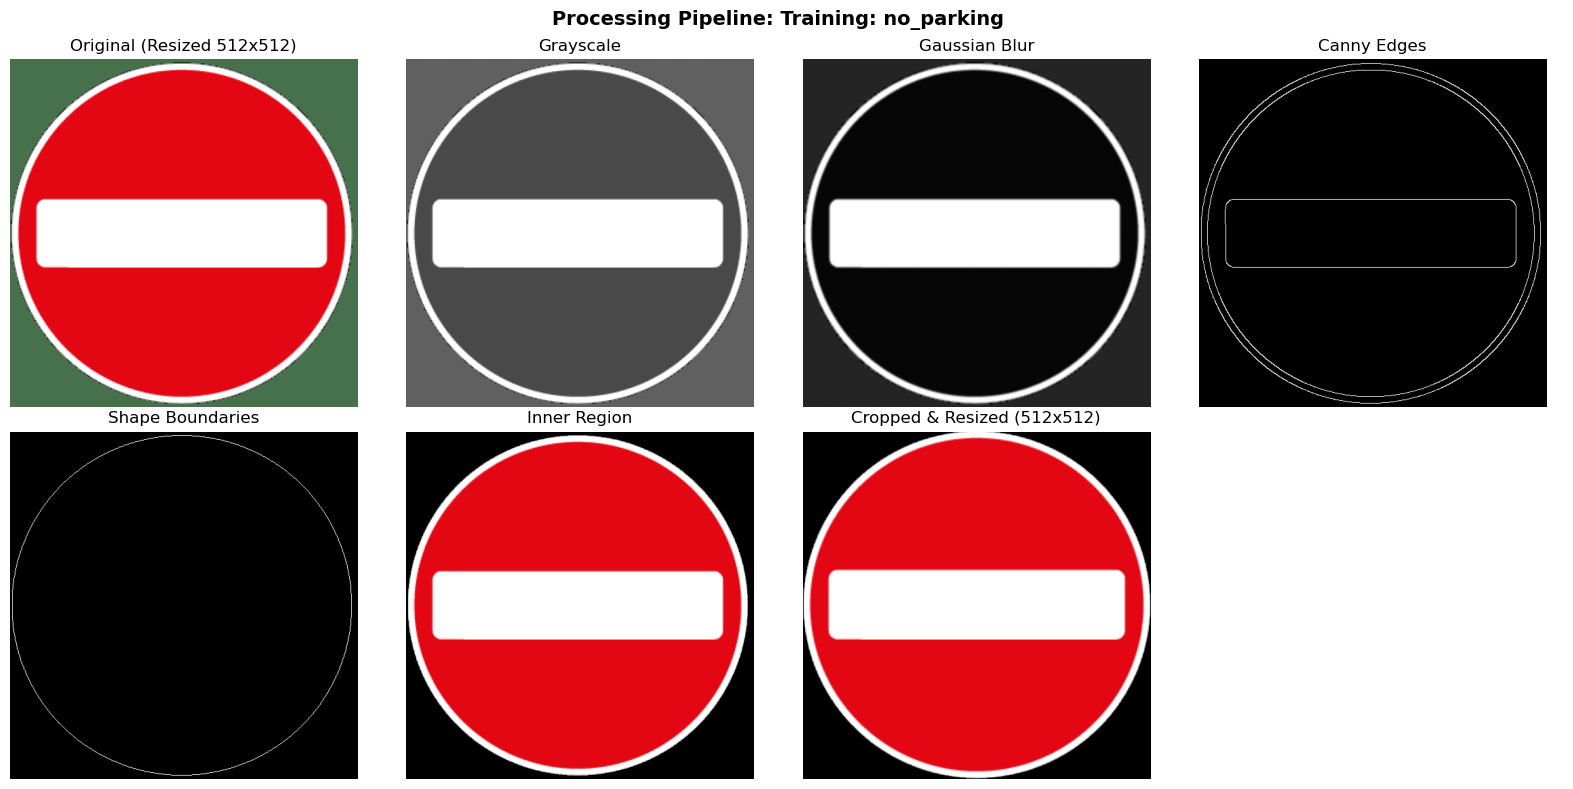

✓ Processed: no_parking


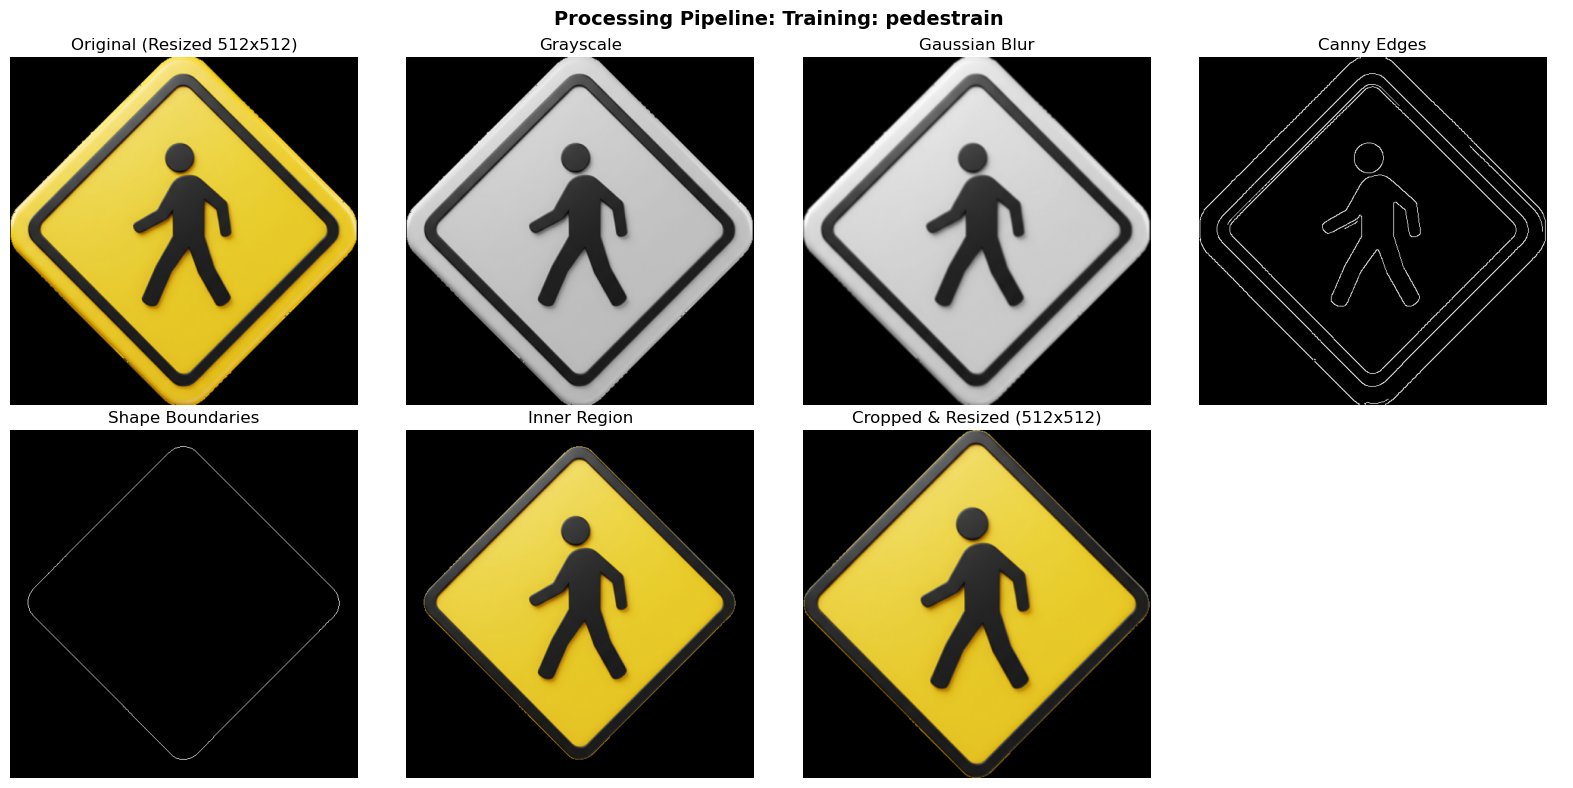

✓ Processed: pedestrain


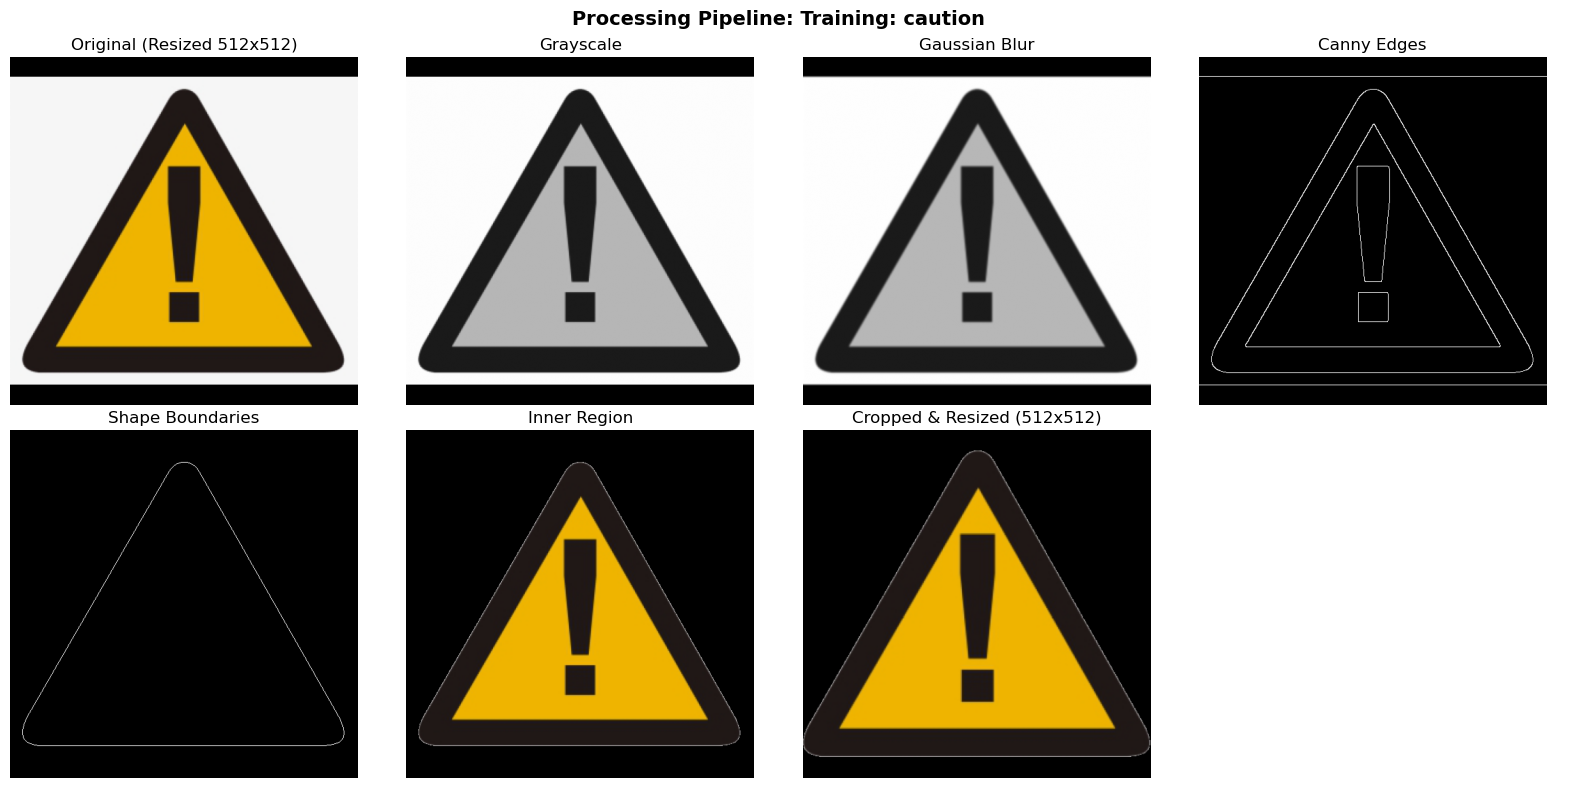

✓ Processed: caution

TESTING PHASE: Template Matching...


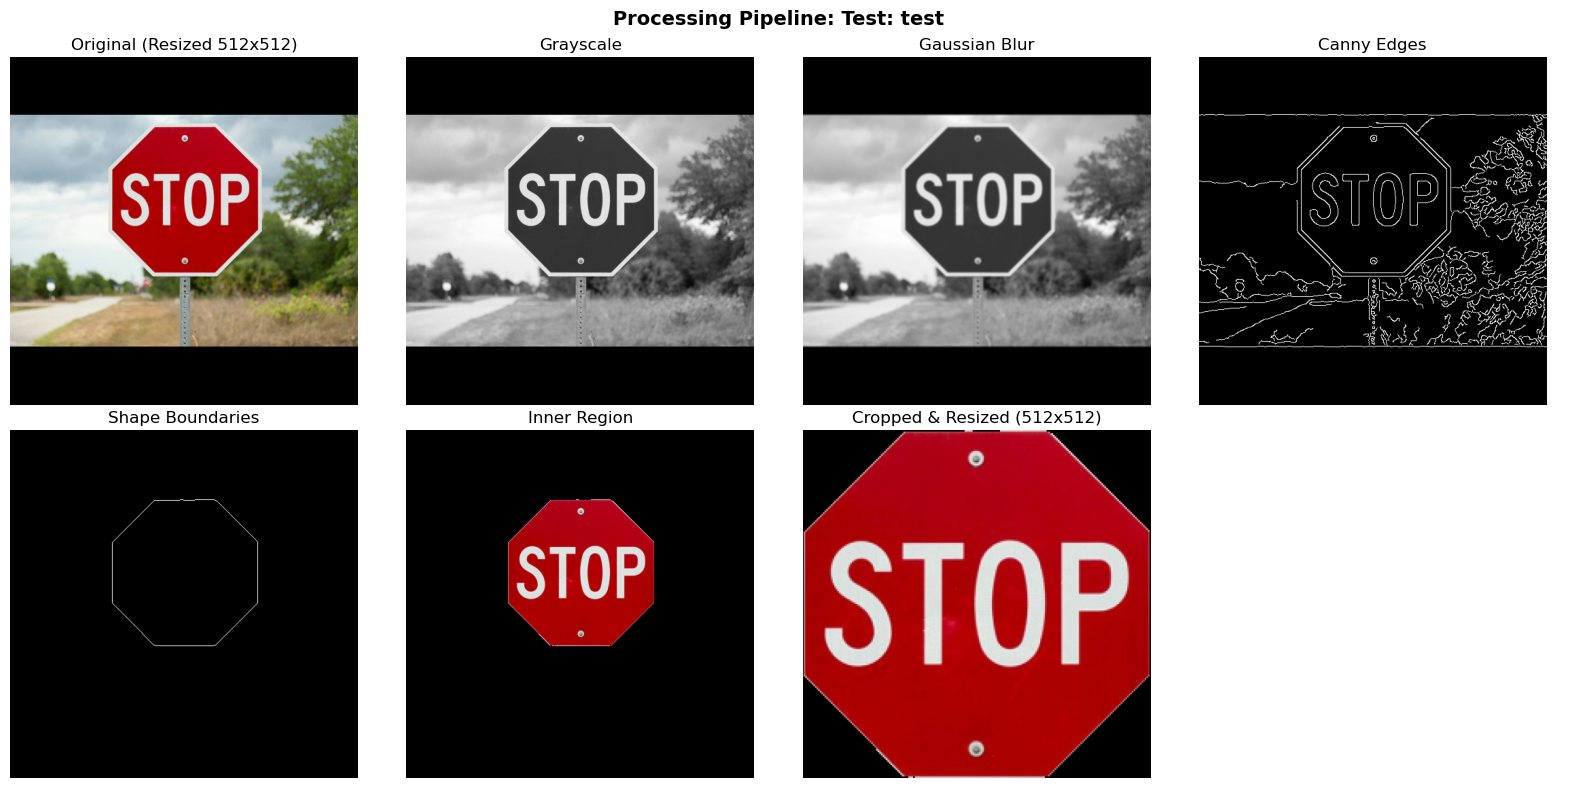

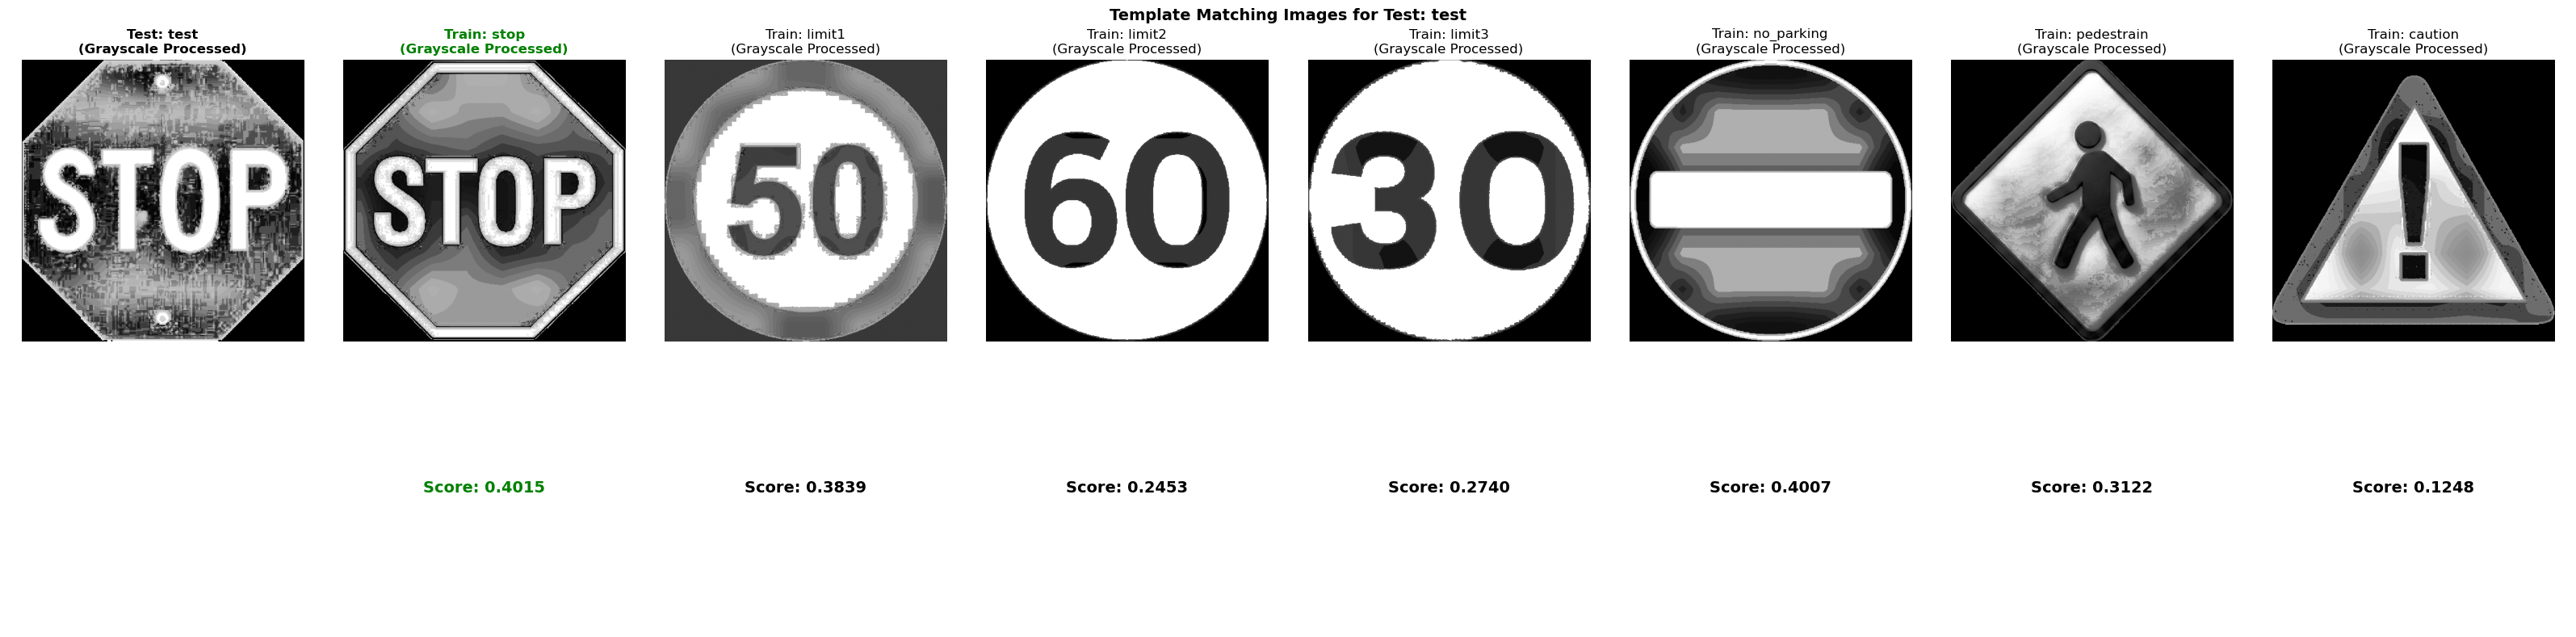

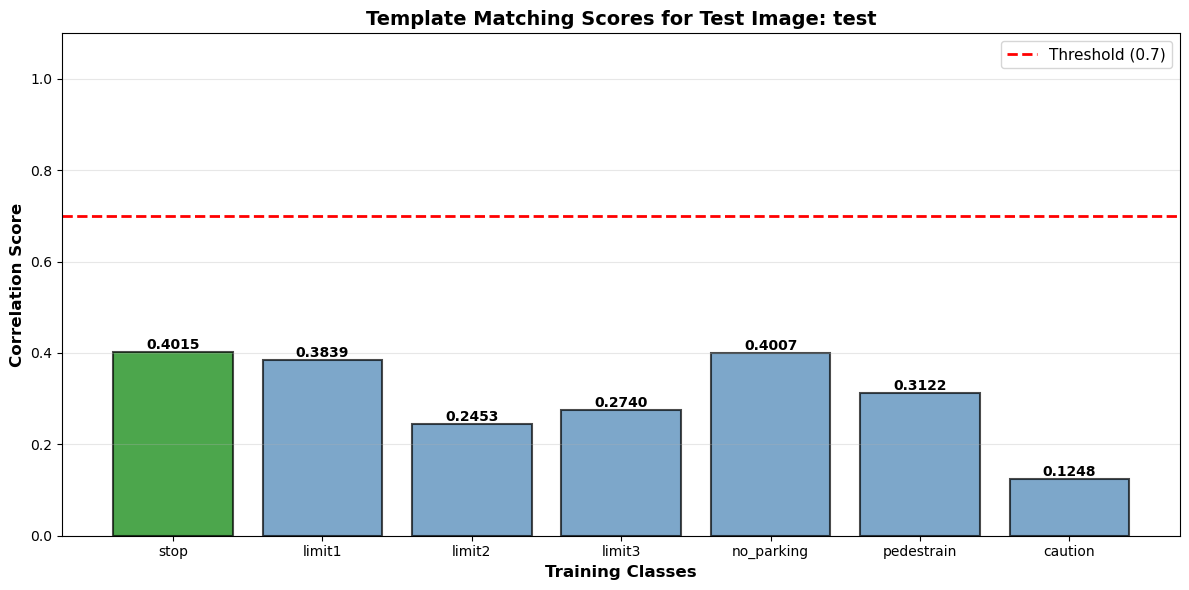

test => NO MATCH (best score: 0.401534)

TEMPLATE MATCHING CORRELATION SCORES
+--------------+----------+----------+----------+----------+--------------+--------------+-----------+----------------+
| Test Image   |     stop |   limit1 |   limit2 |   limit3 |   no_parking |   pedestrain |   caution | Match Result   |
+==============+==========+==========+==========+==========+==============+==============+===========+================+
| test         | 0.401534 | 0.383852 | 0.245332 | 0.273961 |     0.400721 |     0.312238 |  0.124794 | NO MATCH       |
+--------------+----------+----------+----------+----------+--------------+--------------+-----------+----------------+

MATCHING SUMMARY
Correlation Threshold: 0.7
Total Tests: 1
Matches Found: 0
No Match: 1
  ✗ NO MATCH | test => Unknown (0.401534)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tabulate import tabulate

# ===== PREPROCESSING FUNCTIONS =====
def apply_clahe(gray_image, clip_limit=2.0, tile_size=8):
    """Apply Contrast Limited Adaptive Histogram Equalization"""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    return clahe.apply(gray_image)

def gaussian_blur_canny(image, kernel_size=5, canny_low=50, canny_high=150, use_clahe=True):
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    if use_clahe:
        gray = apply_clahe(gray)
    
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    return edges

def extract_shape_boundaries(image, kernel_size=5, min_area=100):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = np.zeros_like(image)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area: 
            cv2.drawContours(result, [contour], -1, 255, 1)
    
    return result

def extract_inner_region(original_image, boundary_image):
    mask = boundary_image.copy()
    contours, _ = cv2.findContours(boundary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        cv2.fillPoly(mask, [contour], 255)
    
    mask_normalized = mask.astype(np.float32) / 255.0
    
    if len(original_image.shape) == 3:  
        result = original_image.copy().astype(np.float32)
        for i in range(3):
            result[:, :, i] = result[:, :, i] * mask_normalized
        result = result.astype(np.uint8)
    else: 
        result = (original_image.astype(np.float32) * mask_normalized).astype(np.uint8)
    
    return result, mask

def extract_inner_region_cropped(original_image, boundary_image):
    # Get the inner region first
    inner_image, mask = extract_inner_region(original_image, boundary_image)
    
    # Find the bounding box of the shape
    contours, _ = cv2.findContours(boundary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # Get the largest contour (main shape)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Crop to the bounding box
        cropped = inner_image[y:y+h, x:x+w]
        
        return cropped, (x, y, w, h)
    
    return inner_image, None

def resize_image(image, target_size=512):
    """Resize image to target size while maintaining aspect ratio and padding"""
    h, w = image.shape[:2]
    
    # Calculate scale to fit image within target_size
    scale = min(target_size / h, target_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    
    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas of target size
    if len(resized.shape) == 3:
        canvas = np.zeros((target_size, target_size, resized.shape[2]), dtype=resized.dtype)
    else:
        canvas = np.zeros((target_size, target_size), dtype=resized.dtype)
    
    # Center the resized image on canvas
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2
    
    if len(resized.shape) == 3:
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w, :] = resized
    else:
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return canvas

def normalize_image_intensity(img, reference_img=None):
    """
    Normalize image intensity to match reference image lighting
    If no reference, normalize to standard intensity
    """
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img.copy()
    
    # Calculate mean intensity
    img_mean = np.mean(img_gray)
    
    if reference_img is not None:
        if len(reference_img.shape) == 3:
            ref_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
        else:
            ref_gray = reference_img.copy()
        ref_mean = np.mean(ref_gray)
        
        # Adjust image intensity to match reference
        intensity_ratio = ref_mean / (img_mean + 1e-10)
    else:
        # Normalize to standard intensity (127.5)
        intensity_ratio = 127.5 / (img_mean + 1e-10)
    
    # Apply intensity normalization
    if len(img.shape) == 3:
        normalized = img.astype(np.float32) * intensity_ratio
        normalized = np.clip(normalized, 0, 255).astype(np.uint8)
    else:
        normalized = img.astype(np.float32) * intensity_ratio
        normalized = np.clip(normalized, 0, 255).astype(np.uint8)
    
    return normalized

# ===== TEMPLATE MATCHING =====
def prepare_matching_image(image):
    """Prepare image for template matching with all preprocessing"""
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Ensure intensity is in 0-255 range
    gray = np.clip(gray.astype(np.float32), 0, 255).astype(np.uint8)
    
    # Apply CLAHE for lighting normalization
    gray = apply_clahe(gray, clip_limit=2.0, tile_size=8)
    
    # Apply histogram equalization as additional normalization
    gray = cv2.equalizeHist(gray)
    
    # Ensure intensity is in 0-255 range after processing
    gray = np.clip(gray.astype(np.float32), 0, 255).astype(np.uint8)
    
    return gray

def template_match(test_image, training_image, method=cv2.TM_CCOEFF_NORMED):
    """
    Template matching between test and training image with lighting normalization
    Returns: correlation score (higher is better, range: 0-1), processed images
    """
    # Prepare images for matching
    test_gray = prepare_matching_image(test_image)
    train_gray = prepare_matching_image(training_image)
    
    # Ensure test is smaller than training for template matching
    if test_gray.shape[0] > train_gray.shape[0] or test_gray.shape[1] > train_gray.shape[1]:
        test_gray, train_gray = train_gray, test_gray
    
    # Perform template matching
    result = cv2.matchTemplate(train_gray, test_gray, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # Normalize correlation to 0-1 range
    correlation_score = max_val
    
    return correlation_score, test_gray, train_gray

def process_image_pipeline(image_path, plot_intermediate=False, title="", min_area=500, target_size=512):
    """Complete pipeline: read -> resize -> detect edges -> extract region -> crop"""
    img = cv2.imread(image_path, 1)
    
    # Step 0: Resize to standard size
    img = resize_image(img, target_size=target_size)
    
    # Step 1: Edge detection
    edges = gaussian_blur_canny(img)
    
    # Step 2: Extract shape boundaries
    boundaries = extract_shape_boundaries(edges, min_area=min_area)
    
    # Step 3: Extract inner region and crop
    cropped_region, bbox = extract_inner_region_cropped(img, boundaries)
    
    # If cropping failed, use full inner region
    if cropped_region is None:
        inner_region, mask = extract_inner_region(img, boundaries)
        cropped_region = inner_region
    
    # Step 4: Resize cropped region to standard size
    cropped_region = resize_image(cropped_region, target_size=target_size)
    
    # Plot intermediate results if requested
    if plot_intermediate:
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
        
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f'Processing Pipeline: {title}', fontsize=14, fontweight='bold')
        
        axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original (Resized 512x512)')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(gray, cmap='gray')
        axes[0, 1].set_title('Grayscale')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(blurred, cmap='gray')
        axes[0, 2].set_title('Gaussian Blur')
        axes[0, 2].axis('off')
        
        axes[0, 3].imshow(edges, cmap='gray')
        axes[0, 3].set_title('Canny Edges')
        axes[0, 3].axis('off')
        
        axes[1, 0].imshow(boundaries, cmap='gray')
        axes[1, 0].set_title('Shape Boundaries')
        axes[1, 0].axis('off')
        
        inner_region, mask = extract_inner_region(img, boundaries)
        axes[1, 1].imshow(cv2.cvtColor(inner_region, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('Inner Region')
        axes[1, 1].axis('off')
        
        if len(cropped_region.shape) == 3:
            axes[1, 2].imshow(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
        else:
            axes[1, 2].imshow(cropped_region, cmap='gray')
        axes[1, 2].set_title('Cropped & Resized (512x512)')
        axes[1, 2].axis('off')
        
        axes[1, 3].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return cropped_region

def plot_matching_comparison(test_name, test_gray, train_names, train_grays, scores, best_idx):
    """Plot the grayscale images used for template matching"""
    n_trains = len(train_names)
    fig, axes = plt.subplots(2, n_trains + 1, figsize=(4 * (n_trains + 1), 8))
    fig.suptitle(f'Template Matching Images for Test: {test_name}', fontsize=14, fontweight='bold')
    
    # First column: Test image
    axes[0, 0].imshow(test_gray, cmap='gray')
    axes[0, 0].set_title(f'Test: {test_name}\n(Grayscale Processed)', fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    # Remaining columns: Training images with scores
    for i, (name, train_gray, score) in enumerate(zip(train_names, train_grays, scores)):
        col = i + 1
        
        # Top row: Training image
        axes[0, col].imshow(train_gray, cmap='gray')
        title_color = 'green' if i == best_idx else 'black'
        axes[0, col].set_title(f'Train: {name}\n(Grayscale Processed)', 
                               fontweight='bold' if i == best_idx else 'normal',
                               color=title_color)
        axes[0, col].axis('off')
        
        # Bottom row: Score
        axes[1, col].text(0.5, 0.5, f'Score: {score:.4f}', 
                         ha='center', va='center', fontsize=14, fontweight='bold',
                         color=title_color,
                         transform=axes[1, col].transAxes)
        axes[1, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_distance_comparison(training_names, scores, best_idx, test_name, threshold):
    """Plot bar chart comparing correlation scores"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['green' if i == best_idx else 'steelblue' for i in range(len(scores))]
    bars = ax.bar(training_names, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add threshold line
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Correlation Score', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Classes', fontsize=12, fontweight='bold')
    ax.set_title(f'Template Matching Scores for Test Image: {test_name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.show()

# ===== MAIN WORKFLOW =====

# Step 1: Define training images dictionary
training_images = {
    'stop': 'train/stop.jpg',
    'limit1': 'train/limit1.jpg',
    'limit2': 'train/limit2.png',
    'limit3': 'train/limit3.jpg',
    'no_parking': 'train/nop.png',
    'pedestrain': 'train/pedes.png',
    'caution': 'train/caution.jpg',
}

# Step 2: Process training images
print("=" * 60)
print("TRAINING PHASE: Processing training images...")
print("=" * 60)

training_images_processed = {}
training_names = list(training_images.keys())

for name, path in training_images.items():
    try:
        cropped = process_image_pipeline(path, plot_intermediate=True, title=f"Training: {name}")
        training_images_processed[name] = cropped
        print(f"✓ Processed: {name}")
    except Exception as e:
        print(f"✗ Error processing {name}: {e}")

# Step 3: Define test images dictionary
test_images = {
    'test': 'train/test1.jpg',
}

# Step 4: Process test images and compare
print("\n" + "=" * 60)
print("TESTING PHASE: Template Matching...")
print("=" * 60)

CORRELATION_THRESHOLD = 0.7  # Adjust this threshold (0-1 range)

results_table = []
matching_results = []

for test_name, test_path in test_images.items():
    try:
        test_cropped = process_image_pipeline(
            test_path, plot_intermediate=True, title=f"Test: {test_name}"
        )
        
        # Calculate correlation scores with all training images
        scores = []
        train_grays = []  # Store processed grayscale images
        test_gray = None
        
        for train_name, train_image in training_images_processed.items():
            # Normalize test image intensity to match training image
            test_normalized = normalize_image_intensity(test_cropped, train_image)
            
            score, t_gray, tr_gray = template_match(test_normalized, train_image)
            scores.append(score)
            train_grays.append(tr_gray)
            if test_gray is None:
                test_gray = t_gray
        
        best_idx = np.argmax(scores)
        best_score = scores[best_idx]
        is_match = best_score > CORRELATION_THRESHOLD
        
        # Plot grayscale images used for matching
        plot_matching_comparison(test_name, test_gray, training_names, train_grays, scores, best_idx)
        
        # Plot correlation comparison
        plot_distance_comparison(training_names, scores, best_idx, test_name, CORRELATION_THRESHOLD)
        
        # Create table row
        row = [test_name]
        for score in scores:
            row.append(f'{score:.6f}')
        
        if is_match:
            matched_label = training_names[best_idx]
            result = f"{test_name} => {matched_label} (score: {best_score:.6f})"
            row.append(matched_label)
        else:
            result = f"{test_name} => NO MATCH (best score: {best_score:.6f})"
            row.append("NO MATCH")
        
        results_table.append(row)
        matching_results.append({
            'test_name': test_name,
            'matched': is_match,
            'match_class': training_names[best_idx] if is_match else "Unknown",
            'score': best_score
        })
        
        print(result)
        
    except Exception as e:
        print(f"✗ Error processing test image {test_name}: {e}")

# Step 5: Display results table
print("\n" + "=" * 60)
print("TEMPLATE MATCHING CORRELATION SCORES")
print("=" * 60)
headers = ['Test Image'] + training_names + ['Match Result']
print(tabulate(results_table, headers=headers, tablefmt='grid'))

# Step 6: Summary
print("\n" + "=" * 60)
print("MATCHING SUMMARY")
print("=" * 60)
print(f"Correlation Threshold: {CORRELATION_THRESHOLD}")
print(f"Total Tests: {len(matching_results)}")
matches_found = sum(1 for r in matching_results if r['matched'])
print(f"Matches Found: {matches_found}")
print(f"No Match: {len(matching_results) - matches_found}")

for result in matching_results:
    status = "✓ MATCH" if result['matched'] else "✗ NO MATCH"
    print(f"  {status} | {result['test_name']} => {result['match_class']} ({result['score']:.6f})")